# Rainbow DQN from Scratch

# Imports & Constants

In [1]:
import sys
import os

# Assuming the notebook is located inside `subfolder` and
# we want to import a module in `parent_folder`

# Get the absolute path to the 'subfolder'.
notebook_dir = os.path.dirname(os.path.abspath("__file__"))

# Calculate the path to the 'parent_folder' by going one level up.
parent_dir = os.path.dirname(notebook_dir)

# Add the 'parent_folder' to sys.path if it is not already there.
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

In [2]:
import os
import math
import time
import random

import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd

from numpy import float64, ndarray
from IPython.display import clear_output
from collections import deque
from typing import Dict, List, Tuple, Deque
from torch.nn.utils import clip_grad_norm_

from agents import MlpDQNAgent
from buffers import NStepReplayBuffer
from networks import Network
from trees import MinSegmentTree, SumSegmentTree
from layers import NoisyLinear

# Modified Prioritised Replay Buffer

In [3]:
class PrioritisedReplayBuffer(NStepReplayBuffer):
    """
    Class representing a Prioritised Replay Buffer with N-step returns.
    """

    def __init__(
            self, 
            obs_shape: Tuple, 
            size: int, 
            batch_size: int = 32, 
            alpha: float = 0.6,
            n_step: int = 1,
            gamma: float = 0.99,
        ):
        """
        Instantiates a PrioritisedReplayBuffer.
        """
        super().__init__(obs_shape, size, batch_size, n_step, gamma)
        self.alpha = alpha

        self.max_priority = 1
        self.tree_ptr = 0

        # The capacity must be positive and a power of 2.
        tree_capcity = 1
        while tree_capcity < self.max_size:
            tree_capcity *= 2

        self.sum_tree = SumSegmentTree(tree_capcity)
        self.min_tree = MinSegmentTree(tree_capcity)

    def store(self, obs: ndarray, act: ndarray, rew: ndarray, next_obs: ndarray, done: bool):
        """
        Stores the experience and its associated priority.
        """
        transition = super().store(obs, act, rew, next_obs, done)

        if transition:
            self.sum_tree[self.tree_ptr] = self.max_priority ** self.alpha
            self.min_tree[self.tree_ptr] = self.max_priority ** self.alpha
            self.tree_ptr = (self.tree_ptr + 1) % self.max_size

        return transition

    def sample_batch(self, beta: float = 0.4) -> Dict[str, ndarray]:
        """
        Samples a batch of experiences with prioritised replay.
        """
        indices = self._sample_proportional()
        weights = np.array([self._calculate_weight(idx, beta) for idx in indices])

        return dict(
            obs=self.obs_buf[indices],
            next_obs=self.next_obs_buf[indices],
            acts=self.acts_buf[indices],
            rews=self.rews_buf[indices],
            done=self.done_buf[indices],
            weights=weights,
            indices=indices,
        )
    
    def update_priorities(self, indices: List[int], priorities: np.ndarray):
        """
        Updates the priorities of sample transitions.
        """
        for idx, priority in zip(indices, priorities):
            self.sum_tree[idx] = priority ** self.alpha
            self.min_tree[idx] = priority ** self.alpha

            self.max_priority = max(self.max_priority, priority)

    def _sample_proportional(self) -> List[int]:
        """
        Samples indices based on proportions.
        """
        indices = []
        p_total = self.sum_tree.sum(0, self.size - 1)
        segment = p_total / self.batch_size

        for i in range(self.batch_size):
            a = segment * i
            b = segment * (i + 1)
            upperbound = random.uniform(a, b)
            idx = self.sum_tree.retrieve(upperbound)
            indices.append(idx)

        return indices
    
    def _calculate_weight(self, idx: int, beta: float) -> float:
        """
        Calculates the weight of the experience at `idx`.
        """
        p_min = self.min_tree.min() / self.sum_tree.sum()
        max_weight = (p_min * self.size) ** (-beta)

        p_sample = self.sum_tree[idx] / self.sum_tree.sum()
        weight = (p_sample * self.size) ** (-beta)
        weight = weight / max_weight
        
        return weight

# Noisy + Dueling + Categorical Networks

[`NoisyLinear`](../layers.py) layers are employed for the last two layers of advantage and value layers. This noise is reset every update step (everytime `update_model` is called).

In [4]:
class RainbowNetwork(nn.Module):

    def __init__(
        self,
        in_dim: int,
        out_dim: int,
        atom_size: int,
        support: torch.Tensor,
    ):
        """
        Instantiates a RainbowNetwork.
        """
        super().__init__()

        self.support = support
        self.out_dim = out_dim
        self.in_dim = in_dim
        self.atom_size = atom_size

        # Common feature layer.
        self.feature_layer = nn.Sequential(
            nn.Linear(in_dim, 128),
            nn.ReLU(),
        )

        # Action advantage layer.
        self.advantage_hidden_layer = NoisyLinear(128, 128)
        self.advantage_layer = NoisyLinear(128, out_dim * atom_size)

        # State value layer.
        self.value_hidden_layer = NoisyLinear(128, 128)
        self.value_layer = NoisyLinear(128, atom_size)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Performs a forward pass of the neural network.
        """
        dist = self.dist(x)
        q = torch.sum(dist * self.support, dim=2)

        return q
    
    def dist(self, x: torch.Tensor) -> torch.Tensor:
        """
        Gets a distribution over atoms.
        """
        feature = self.feature_layer(x)

        avd_hid = F.relu(self.advantage_hidden_layer(feature))
        val_hid = F.relu(self.value_hidden_layer(feature))

        advantage = self.advantage_layer(avd_hid).view(
            -1, self.out_dim, self.atom_size
        )
        value = self.value_layer(val_hid).view(
            -1, 1, self.atom_size
        )

        q_atoms = value + advantage - advantage.mean(dim=1, keepdim=True)

        dist = F.softmax(q_atoms, dim=-1)
        # To avoid NaNs
        dist = dist.clamp(min=1e-3)

        return dist
    
    def reset_noise(self):
        """
        Resets all the noisy layers.
        """
        self.advantage_hidden_layer.reset_noise()
        self.advantage_layer.reset_noise()
        self.value_hidden_layer.reset_noise()
        self.value_layer.reset_noise()

# Rainbow DQN Agent

In [ ]:
from typing import Dict
from numpy import ndarray
from torch._tensor import Tensor

In [5]:
class RainbowDQNAgent(MlpDQNAgent):

    def __init__(
        self,        
        env: gym.Env,
        memory_size: int,
        batch_size: int,
        target_update: int,
        seed: int = 42,
        gamma = 0.99,
        # Priortised Experience Replay Params
        alpha: float = 0.2,
        beta: float = 0.6,
        prior_eps: float = 1e-6,
        # Categorical DQN Params
        v_min: float = 0.0,
        v_max: float = 200.0,
        atom_size: int = 51,
        # N-step Learning
        n_step: int = 3,
    ):
        super().__init__(
            env,
            memory_size,
            batch_size,
            target_update,
            seed=seed,
            gamma=gamma,
        )

        # Prioritised Replay Buffer. This is the memory for 1-step learning.
        self.beta = beta
        self.alpha = alpha
        self.prior_eps = prior_eps
        self.memory = PrioritisedReplayBuffer(
            self.obs_shape, memory_size, batch_size, alpha=alpha, gamma=gamma
        )

        # Memory for N-step learning.
        self.use_n_step = n_step > 1
        if self.use_n_step:
            self.n_step = n_step
            self.memory_n = NStepReplayBuffer(
                self.obs_shape, memory_size, batch_size, n_step=n_step, gamma=gamma
            )

        # Categorical DQN Parameters.
        self.v_min = v_min
        self.v_max = v_max
        self.atom_size = atom_size
        self.support = torch.linspace(
            v_min, v_max, atom_size
        ).to(self.device)

        # Value networks
        self.dqn = RainbowNetwork(
            self.obs_dim, self.action_dim, atom_size, self.support
        ).to(self.device)
        self.dqn_target = RainbowNetwork(
            self.obs_dim, self.action_dim, atom_size, self.support
        ).to(self.device)
        self.dqn_target.load_state_dict(self.dqn.state_dict())
        self.dqn_target.eval()

        # Optimiser
        self.optimiser = optim.Adam(self.dqn.parameters())

    def select_action(self, state: np.ndarray, determinstic: bool = False) -> np.ndarray:
        # As we are using noisy networks, we do not use an epsilon-greedy policy for
        # action selection.
        flattened_state = state.flatten()

        selected_action = self.dqn(
            torch.Tensor(flattened_state).to(self.device)
        ).argmax()
        selected_action = selected_action.detach().cpu().numpy()

        if not self.is_test:
            self.transition = [state, selected_action]

        return selected_action
    
    def step(self, action: ndarray) -> Tuple[ndarray, float64, bool]:
        next_state, reward, terminated, truncated, _ = self.env.step(action)
        done = terminated or truncated
        
        if not self.is_test:
            self.transition += [reward, next_state, done]
            
            # N-step transition
            if self.use_n_step:
                one_step_transition = self.memory_n.store(*self.transition)
            # 1-step transition
            else:
                one_step_transition = self.transition

            # Add a single step transition
            if one_step_transition:
                self.memory.store(*one_step_transition)
    
        return next_state, reward, done
    
    def update_model(self) -> Tensor:
        # PER uses beta to calculate the weights.
        samples = self.memory.sample_batch(self.beta)

        weights = torch.FloatTensor(
            samples["weights"].reshape(-1, 1)
        ).to(self.device)
        indices = samples["indices"]

        # 1-step learning loss.
        elementwise_loss = self._compute_dqn_loss(samples, self.gamma)

        # N-step learning loss. We combine 1-step and n-step loss so as to
        # prevent high variance. The original RainbowDQN employs only n-step.
        if self.use_n_step:
            gamma = self.gamma ** self.n_step
            samples = self.memory_n.sample_batch_from_idxs(indices)

            elementwise_loss_n = self._compute_dqn_loss(samples, gamma)
            elementwise_loss += elementwise_loss_n

        # PER: Importance sampling before averaging.
        loss = torch.mean(elementwise_loss * weights)

        self.optimiser.zero_grad()
        loss.backward()

        # Dueling Networks: We clip the gradients to prevent exploding gradients.
        clip_grad_norm_(self.dqn.parameters(), 10.0)
        self.optimiser.step()

        # PER: Update experience priorities.
        loss_for_prior = elementwise_loss.detach().cpu().numpy()
        new_priorities = loss_for_prior + self.prior_eps
        self.memory.update_priorities(indices, new_priorities)

        # Noisy Network: Reset the noise in the noisy network layers.
        self.dqn.reset_noise()
        self.dqn_target.reset_noise()

        return loss.item()
    
    def train(self, num_frames: int, plotting_interval: int = 200):
        """
        Trains the agent.
        """
        self.is_test = False
        state, _ = self.env.reset()

        update_count = 0
        losses = []
        scores = []
        score = 0

        for frame_idx in range(num_frames):
            action = self.select_action(state)
            next_state, reward, done = self.step(action)

            state = next_state
            score += reward

            # PER: Increase param beta.
            fraction = min(frame_idx / num_frames, 1.0)
            self.beta = self.beta + fraction * (1.0 - self.beta)

            if done:
                # The episode has ended.
                state, _ = self.env.reset()
                scores.append(score)
                score = 0

            if len(self.memory) >= self.batch_size:
                # Training is ready once the replay buffer contains enough transition samples.
                loss = self.update_model()
                losses.append(loss)
                update_count += 1

                # Noisy Networks: Removed decrease of epsilon.

                # If a hard update of the target network is needed.
                if update_count % self.target_update == 0:
                    self._target_hard_update()

            if (frame_idx + 1) % plotting_interval == 0:
                self._plot(frame_idx + 1, scores, losses, [])

        self.env.close()

        return scores, losses, []

    def _compute_dqn_loss(self, samples: Dict[str, ndarray], gamma: float = None) -> torch.Tensor:
        """
        Computes and returns the Categorical DQN loss.
        """
        if gamma is None:
            gamma = self.gamma

        device = self.device
        # Shape = (batch_size, obs dim 1, obs dim 2, ...)
        # This flattens the observation dimensions of `state` and `next_state`.
        state = torch.FloatTensor(samples["obs"].reshape(self.batch_size, -1)).to(device)
        next_state = torch.FloatTensor(samples["next_obs"].reshape(self.batch_size, -1)).to(device)

        # Reshapes each 1-dimesional array into a 2-dimensional array with one column.
        action = torch.LongTensor(samples["acts"]).to(device)
        reward = torch.FloatTensor(samples["rews"].reshape(-1, 1)).to(device)
        done = torch.FloatTensor(samples["done"].reshape(-1, 1)).to(device)

        # Categorical DQN algorithm
        delta_z = float(self.v_max - self.v_min) / (self.atom_size - 1)

        with torch.no_grad():
            # Double DQN
            next_action = self.dqn(next_state).argmax(1)
            next_dist = self.dqn_target.dist(next_state)
            next_dist = next_dist[range(self.batch_size), next_action]

            t_z = reward + (1 - done) * gamma * self.support
            t_z = t_z.clamp(min=self.v_min, max=self.v_max)
            b = (t_z - self.v_min) / delta_z
            l = b.floor().long()
            u = b.ceil().long()

            offset = (
                torch.linspace(
                    0, (self.batch_size - 1) * self.atom_size, self.batch_size
                ).long()
                .unsqueeze(1)
                .expand(self.batch_size, self.atom_size)
                .to(self.device)
            )

            proj_dist = torch.zeros(next_dist.size(), device=self.device)
            proj_dist.view(-1).index_add_(
                0, (l + offset).view(-1), (next_dist * (u.float() - b)).view(-1)
            )
            proj_dist.view(-1).index_add_(
                0, (u + offset).view(-1), (next_dist * (b - l.float())).view(-1)
            )
        
        dist = self.dqn.dist(state)
        log_p = torch.log(dist[range(self.batch_size), action])
        elementwise_loss = -(proj_dist * log_p).sum(1)

        return elementwise_loss

# Train an Agent

In [6]:
config = {
    'lanes_count': 4,
    'duration': 50,
}

In [7]:
env = gym.make("highway-fast-v0", render_mode="rgb_array")
env.unwrapped.configure(config)
obs, info = env.reset()

In [10]:
seed = 777
num_frames = 400_000
memory_size = 20_000
gamma = 0.85
batch_size = 64
target_update = 50

agent = RainbowDQNAgent(
    env,
    memory_size,
    batch_size,
    target_update,
    seed=seed,
    gamma=gamma
)

cuda


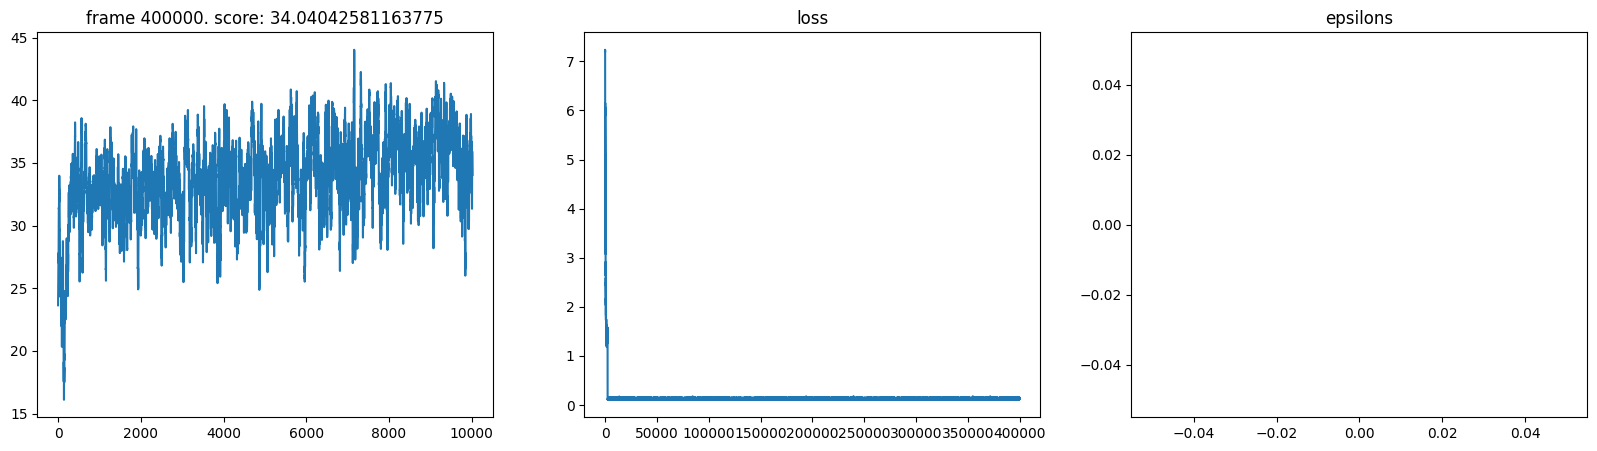

In [11]:
scores, losses, epsilons = agent.train(num_frames)

In [ ]:
# pd.DataFrame({"Rainbow DQN": scores}).to_csv("../results/rainbow_dqn.csv")

# Test the Agent

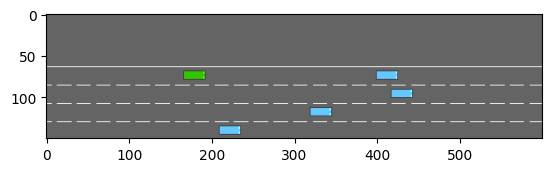

In [ ]:
ep_lens, ep_rews = agent.test(1, time_interval=0.01)

In [ ]:
print("Mean Episode Length:", np.mean(ep_lens))
print("Mean Score Per Episode:", np.mean(ep_rews))

Mean Episode Length: 36.83
Mean Score Per Episode: 32.993678937494394


# Film the agent

In [12]:
from gymnasium.wrappers import RecordVideo
from agents import BaseDQNAgent

In [13]:
env = gym.make("highway-v0", render_mode="rgb_array")

In [14]:
def film(env: gym.Env, test_agent: BaseDQNAgent, film_length: int, video_folder: str):
    vid_env = RecordVideo(env, video_folder=video_folder,
              episode_trigger=lambda e: True)  # record all episodes

    # Provide the video recorder to the wrapped environment
    # so it can send it intermediate simulation frames.
    vid_env.unwrapped.set_record_video_wrapper(vid_env)

    test_agent.set_mode(is_test=True)

    for i in range(film_length):
        obs, info = vid_env.reset()
        done = truncated = False

        while not (done or truncated):
            action = test_agent.predict(obs, determinstic=True)
            obs, reward, done, truncated, info = vid_env.step(action)
            vid_env.render()
        vid_env.close()

## Before Training

In [15]:
untrained_agent = RainbowDQNAgent(
    env,
    memory_size,
    batch_size,
    target_update,
    seed=seed,
    gamma=gamma
)

film(env, untrained_agent, 10, "../videos/rainbow_dqn/untrained/")

cuda
Moviepy - Building video /home/sowell/projects/rl_group_assignment/videos/rainbow_dqn/untrained/rl-video-episode-0.mp4.
Moviepy - Writing video /home/sowell/projects/rl_group_assignment/videos/rainbow_dqn/untrained/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /home/sowell/projects/rl_group_assignment/videos/rainbow_dqn/untrained/rl-video-episode-0.mp4
Moviepy - Building video /home/sowell/projects/rl_group_assignment/videos/rainbow_dqn/untrained/rl-video-episode-1.mp4.
Moviepy - Writing video /home/sowell/projects/rl_group_assignment/videos/rainbow_dqn/untrained/rl-video-episode-1.mp4



Moviepy - Done !
Moviepy - video ready /home/sowell/projects/rl_group_assignment/videos/rainbow_dqn/untrained/rl-video-episode-1.mp4
Moviepy - Building video /home/sowell/projects/rl_group_assignment/videos/rainbow_dqn/untrained/rl-video-episode-2.mp4.
Moviepy - Writing video /home/sowell/projects/rl_group_assignment/videos/rainbow_dqn/untrained/rl-video-episode-2.mp4



Moviepy - Done !
Moviepy - video ready /home/sowell/projects/rl_group_assignment/videos/rainbow_dqn/untrained/rl-video-episode-2.mp4
Moviepy - Building video /home/sowell/projects/rl_group_assignment/videos/rainbow_dqn/untrained/rl-video-episode-3.mp4.
Moviepy - Writing video /home/sowell/projects/rl_group_assignment/videos/rainbow_dqn/untrained/rl-video-episode-3.mp4



Moviepy - Done !
Moviepy - video ready /home/sowell/projects/rl_group_assignment/videos/rainbow_dqn/untrained/rl-video-episode-3.mp4
Moviepy - Building video /home/sowell/projects/rl_group_assignment/videos/rainbow_dqn/untrained/rl-video-episode-4.mp4.
Moviepy - Writing video /home/sowell/projects/rl_group_assignment/videos/rainbow_dqn/untrained/rl-video-episode-4.mp4



Moviepy - Done !
Moviepy - video ready /home/sowell/projects/rl_group_assignment/videos/rainbow_dqn/untrained/rl-video-episode-4.mp4


Moviepy - Building video /home/sowell/projects/rl_group_assignment/videos/rainbow_dqn/untrained/rl-video-episode-5.mp4.
Moviepy - Writing video /home/sowell/projects/rl_group_assignment/videos/rainbow_dqn/untrained/rl-video-episode-5.mp4



Moviepy - Done !
Moviepy - video ready /home/sowell/projects/rl_group_assignment/videos/rainbow_dqn/untrained/rl-video-episode-5.mp4
Moviepy - Building video /home/sowell/projects/rl_group_assignment/videos/rainbow_dqn/untrained/rl-video-episode-6.mp4.
Moviepy - Writing video /home/sowell/projects/rl_group_assignment/videos/rainbow_dqn/untrained/rl-video-episode-6.mp4



Moviepy - Done !
Moviepy - video ready /home/sowell/projects/rl_group_assignment/videos/rainbow_dqn/untrained/rl-video-episode-6.mp4
Moviepy - Building video /home/sowell/projects/rl_group_assignment/videos/rainbow_dqn/untrained/rl-video-episode-7.mp4.
Moviepy - Writing video /home/sowell/projects/rl_group_assignment/videos/rainbow_dqn/untrained/rl-video-episode-7.mp4



Moviepy - Done !
Moviepy - video ready /home/sowell/projects/rl_group_assignment/videos/rainbow_dqn/untrained/rl-video-episode-7.mp4
Moviepy - Building video /home/sowell/projects/rl_group_assignment/videos/rainbow_dqn/untrained/rl-video-episode-8.mp4.
Moviepy - Writing video /home/sowell/projects/rl_group_assignment/videos/rainbow_dqn/untrained/rl-video-episode-8.mp4



Moviepy - Done !
Moviepy - video ready /home/sowell/projects/rl_group_assignment/videos/rainbow_dqn/untrained/rl-video-episode-8.mp4
Moviepy - Building video /home/sowell/projects/rl_group_assignment/videos/rainbow_dqn/untrained/rl-video-episode-9.mp4.
Moviepy - Writing video /home/sowell/projects/rl_group_assignment/videos/rainbow_dqn/untrained/rl-video-episode-9.mp4



Moviepy - Done !
Moviepy - video ready /home/sowell/projects/rl_group_assignment/videos/rainbow_dqn/untrained/rl-video-episode-9.mp4


## After training

In [16]:
film(env, agent, 10, "../videos/rainbow_dqn/trained/")

Moviepy - Building video /home/sowell/projects/rl_group_assignment/videos/rainbow_dqn/trained/rl-video-episode-0.mp4.
Moviepy - Writing video /home/sowell/projects/rl_group_assignment/videos/rainbow_dqn/trained/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /home/sowell/projects/rl_group_assignment/videos/rainbow_dqn/trained/rl-video-episode-0.mp4
Moviepy - Building video /home/sowell/projects/rl_group_assignment/videos/rainbow_dqn/trained/rl-video-episode-1.mp4.
Moviepy - Writing video /home/sowell/projects/rl_group_assignment/videos/rainbow_dqn/trained/rl-video-episode-1.mp4



Moviepy - Done !
Moviepy - video ready /home/sowell/projects/rl_group_assignment/videos/rainbow_dqn/trained/rl-video-episode-1.mp4
Moviepy - Building video /home/sowell/projects/rl_group_assignment/videos/rainbow_dqn/trained/rl-video-episode-2.mp4.
Moviepy - Writing video /home/sowell/projects/rl_group_assignment/videos/rainbow_dqn/trained/rl-video-episode-2.mp4



Moviepy - Done !
Moviepy - video ready /home/sowell/projects/rl_group_assignment/videos/rainbow_dqn/trained/rl-video-episode-2.mp4
Moviepy - Building video /home/sowell/projects/rl_group_assignment/videos/rainbow_dqn/trained/rl-video-episode-3.mp4.
Moviepy - Writing video /home/sowell/projects/rl_group_assignment/videos/rainbow_dqn/trained/rl-video-episode-3.mp4



Moviepy - Done !
Moviepy - video ready /home/sowell/projects/rl_group_assignment/videos/rainbow_dqn/trained/rl-video-episode-3.mp4
Moviepy - Building video /home/sowell/projects/rl_group_assignment/videos/rainbow_dqn/trained/rl-video-episode-4.mp4.
Moviepy - Writing video /home/sowell/projects/rl_group_assignment/videos/rainbow_dqn/trained/rl-video-episode-4.mp4



Moviepy - Done !
Moviepy - video ready /home/sowell/projects/rl_group_assignment/videos/rainbow_dqn/trained/rl-video-episode-4.mp4


Moviepy - Building video /home/sowell/projects/rl_group_assignment/videos/rainbow_dqn/trained/rl-video-episode-5.mp4.
Moviepy - Writing video /home/sowell/projects/rl_group_assignment/videos/rainbow_dqn/trained/rl-video-episode-5.mp4



Moviepy - Done !
Moviepy - video ready /home/sowell/projects/rl_group_assignment/videos/rainbow_dqn/trained/rl-video-episode-5.mp4
Moviepy - Building video /home/sowell/projects/rl_group_assignment/videos/rainbow_dqn/trained/rl-video-episode-6.mp4.
Moviepy - Writing video /home/sowell/projects/rl_group_assignment/videos/rainbow_dqn/trained/rl-video-episode-6.mp4



Moviepy - Done !
Moviepy - video ready /home/sowell/projects/rl_group_assignment/videos/rainbow_dqn/trained/rl-video-episode-6.mp4
Moviepy - Building video /home/sowell/projects/rl_group_assignment/videos/rainbow_dqn/trained/rl-video-episode-7.mp4.
Moviepy - Writing video /home/sowell/projects/rl_group_assignment/videos/rainbow_dqn/trained/rl-video-episode-7.mp4



Moviepy - Done !
Moviepy - video ready /home/sowell/projects/rl_group_assignment/videos/rainbow_dqn/trained/rl-video-episode-7.mp4
Moviepy - Building video /home/sowell/projects/rl_group_assignment/videos/rainbow_dqn/trained/rl-video-episode-8.mp4.
Moviepy - Writing video /home/sowell/projects/rl_group_assignment/videos/rainbow_dqn/trained/rl-video-episode-8.mp4



Moviepy - Done !
Moviepy - video ready /home/sowell/projects/rl_group_assignment/videos/rainbow_dqn/trained/rl-video-episode-8.mp4
Moviepy - Building video /home/sowell/projects/rl_group_assignment/videos/rainbow_dqn/trained/rl-video-episode-9.mp4.
Moviepy - Writing video /home/sowell/projects/rl_group_assignment/videos/rainbow_dqn/trained/rl-video-episode-9.mp4



Moviepy - Done !
Moviepy - video ready /home/sowell/projects/rl_group_assignment/videos/rainbow_dqn/trained/rl-video-episode-9.mp4
